In [1]:
!pip install -Uqq fastbook

In [2]:
from fastbook import *
import numpy as np
import os

In [3]:
urls = search_images_ddg('bird photos', max_images=10)
len(urls), urls[0]

(10,
 'https://www.hdnicewallpapers.com/Walls/Big/Sparrow/Sparrow_Bird_Wallpaper.jpg')

In [4]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

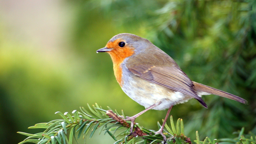

In [5]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [7]:
searches = "forest", "bird"
path = Path("bird_or_not")

if not path.exists():
    path.mkdir()

if path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        #os.mkdir(dest)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

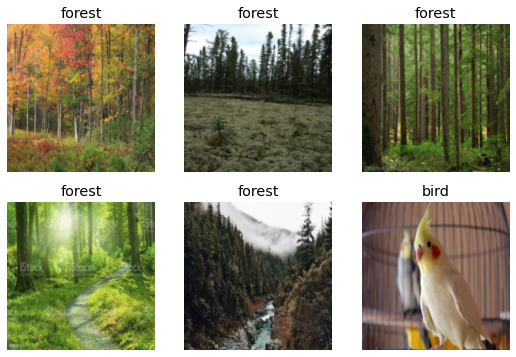

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.678970,0.319066,0.184211,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.071113,0.006174,0.000000,00:49
1,0.048188,0.002140,0.000000,00:49
2,0.032549,0.001668,0.000000,00:49


In [11]:
is_bird,_,probs=learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


In [12]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

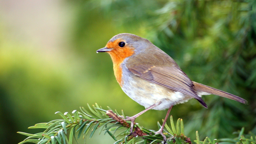

In [13]:
from fastdownload import download_url
dest = "birg.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

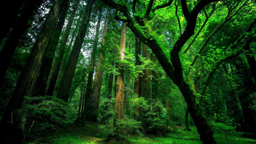

In [14]:
download_url(search_images('forest_photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open("forest.jpg").to_thumb(256,256)

In [ ]:
# searches = "forest","bird"
# path=Path("bird_or_not")

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f"{o} photo"))
#     resize_images(path/o, max_size=400, dest=path/o)

Segmentation model

In [16]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str))

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.869890,2.332957,01:05


epoch,train_loss,valid_loss,time
0,1.732271,1.401700,01:11
1,1.542372,1.172290,01:10
2,1.458505,1.672321,01:09
3,1.388012,1.085320,01:09
4,1.275722,0.913575,01:10
5,1.166990,0.834412,01:09
6,1.073183,0.800331,01:10
7,0.999260,0.797642,01:09
